In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

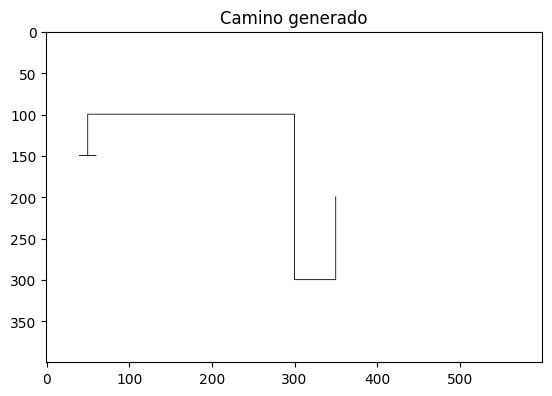

True

In [13]:
# GENERADOR DE IMAGENES - (solo ejecutar esta celda para crear caminos)
img = np.ones((400, 600), dtype=np.uint8) * 255  # 400x600 imagen en blanco

# Dibujar un camino (línea negra) en la imagen
cv2.line(img, (40, 150), (60, 150), (0, 0, 0), thickness=1)
cv2.line(img, (50, 150), (50, 100), (0, 0, 0), thickness=1)
cv2.line(img, (50, 100), (300, 100), (0, 0, 0), thickness=1)
cv2.line(img, (300, 100), (300, 300), (0, 0, 0), thickness=1)
cv2.line(img, (300, 300), (350, 300), (0, 0, 0), thickness=1)
cv2.line(img, (350, 300), (350, 200), (0, 0, 0), thickness=1)

# Mostrar la imagen generada
plt.imshow(img, cmap='gray')
plt.title("Camino generado")
plt.show()

# Guardar la imagen
cv2.imwrite('generated_path.png', img)


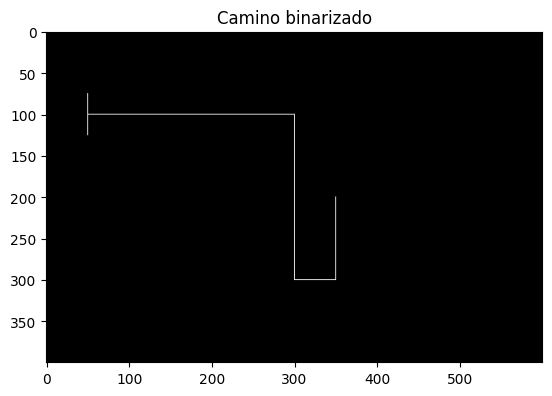

In [23]:
# Cargar imagen de camino
img = cv2.imread('camino-1.png', cv2.IMREAD_GRAYSCALE)

# Umbralización para binarizar la imagen (0: fondo, 1: camino)
_, binary_img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

# Mostrar la imagen binarizada
plt.imshow(binary_img, cmap='gray')
plt.title("Camino binarizado")
plt.show()


In [24]:
def find_starting_point(binary_img):
    height, width = binary_img.shape

    # Direcciones a verificar: arriba, abajo, izquierda, derecha
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # (y, x): arriba, abajo, izquierda, derecha

    for y in range(height):
        for x in range(width):
            if binary_img[y, x] == 255:  # Es un píxel del camino
                valid_directions = 0  # Contador de direcciones válidas

                # Verificar las 4 direcciones
                for dy, dx in directions:
                    new_y, new_x = y + dy, x + dx
                    if 0 <= new_x < width and 0 <= new_y < height:
                        if binary_img[new_y, new_x] == 255:  # Si es camino en la dirección
                            valid_directions += 1

                # Si tiene al menos 3 direcciones válidas, es un posible punto de inicio
                if valid_directions >= 3:
                    return (x, y)

    return None  # Si no se encuentra ningún camino

# Buscar el punto inicial
start_position = find_starting_point(binary_img)

In [25]:
# Función para evaluar las longitudes de los caminos en tres direcciones
def evaluate_directions(start_pos, binary_img):
    height, width = binary_img.shape

    # Definir las tres direcciones candidatas
    directions = [(-1, 0), (1, 0), (0, 1)]  # Arriba, Abajo, Derecha (por ejemplo)

    # Diccionario para guardar la longitud del camino en cada dirección
    lengths = {}

    # Evaluar cada dirección
    for direction in directions:
        dy, dx = direction
        pos = [start_pos[0], start_pos[1]]
        length = 0

        # Moverse en la dirección hasta que se salga del camino o de la imagen
        while 0 <= pos[0] < width and 0 <= pos[1] < height and binary_img[pos[1], pos[0]] == 255:
            length += 1
            pos[0] += dx
            pos[1] += dy

        # Guardar la longitud para esa dirección
        lengths[direction] = length

    # Encontrar la dirección con el camino más largo
    best_direction = max(lengths, key=lengths.get)
    print(f"Mejor dirección: {best_direction}, Longitud: {lengths[best_direction]}")

    return best_direction

In [26]:
def move_robot(start_pos, best_direction, binary_img):
    pos = list(start_pos)
    height, width = binary_img.shape
    path_positions = []

    # Direcciones posibles con prioridad: primero la mejor dirección, luego las demás
    directions = [best_direction, (0, 1), (1, 0), (0, -1), (-1, 0)]  # Mejor dirección seguida de derecha, abajo, izquierda, arriba

    while True:
        path_positions.append(tuple(pos))  # Guardar la posición actual

        # Imprimir la posición actual del robot
        #print(f"Robot en posición: {pos}")

        # Marcar la posición actual como recorrida
        binary_img[pos[1], pos[0]] = 0

        moved = False

        # Buscar en las direcciones con prioridad (empezando con la mejor dirección)
        for direction in directions:
            new_pos = [pos[0] + direction[1], pos[1] + direction[0]]

            # Verificar si el nuevo movimiento está dentro de los límites de la imagen
            if 0 <= new_pos[0] < width and 0 <= new_pos[1] < height:
                # Verificar si el nuevo movimiento está sobre el camino (valor 255 en la imagen binaria)
                if binary_img[new_pos[1], new_pos[0]] == 255:
                    pos = new_pos  # Moverse a la nueva posición
                    moved = True
                    break

        # Si no pudo moverse en ninguna dirección, terminamos
        if not moved:
            print(f"El robot se detuvo en la posición: {pos}")
            break

    return path_positions


Punto de inicio detectado: (50, 100)
Mejor dirección: (0, 1), Longitud: 251
El robot se detuvo en la posición: [350, 200]


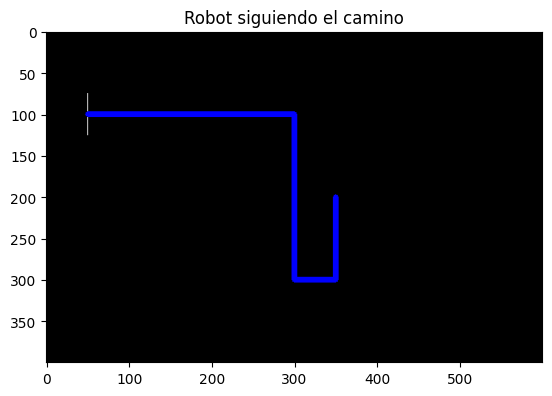

In [27]:
if start_position:
    print(f"Punto de inicio detectado: {start_position}")

    # Evaluar las direcciones y seleccionar la mejor
    best_direction = evaluate_directions(start_position, binary_img)

    # Mover el robot en la mejor dirección
    path = move_robot(start_position, best_direction, binary_img)

    # Dibujar el camino recorrido por el robot
    robot_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)
    for point in path:
        cv2.circle(robot_img, point, radius=3, color=(0, 0, 255), thickness=-1)

    # Mostrar la imagen con el camino recorrido
    plt.imshow(robot_img)
    plt.title("Robot siguiendo el camino")
    plt.show()

else:
    print("No se detectó el punto de inicio.")

In [28]:
# Crear un video del movimiento del robot
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('robot_path_follow.avi', fourcc, 20.0, (600, 400))

# Simular el movimiento del robot cuadro por cuadro
for point in path:
    frame = robot_img.copy()
    cv2.circle(frame, point, radius=5, color=(0, 255, 0), thickness=-1)  # Dibujar el robot en verde
    out.write(frame)  # Escribir cada frame en el video

# Liberar el video
out.release()

print("Video guardado como 'robot_path_follow.avi'")


Video guardado como 'robot_path_follow.avi'
